## Random Forest Classifier

## Exploring the Data

In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score

import visuals as vs

%matplotlib inline

data = pd.read_csv("census.csv")
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Quick Data Exploration 

In [2]:
n_records = len(data)
n_greater_50k = len(data[data.income == ">50K"])
n_at_most_50k = len(data[data.income == "<=50K"])
greater_percent = n_greater_50k*100/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(round(greater_percent,1)))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.8%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


## Preparing the Data


### Transforming Skewed Continuous Features

/home/ktimchen/Untitled Folder/visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


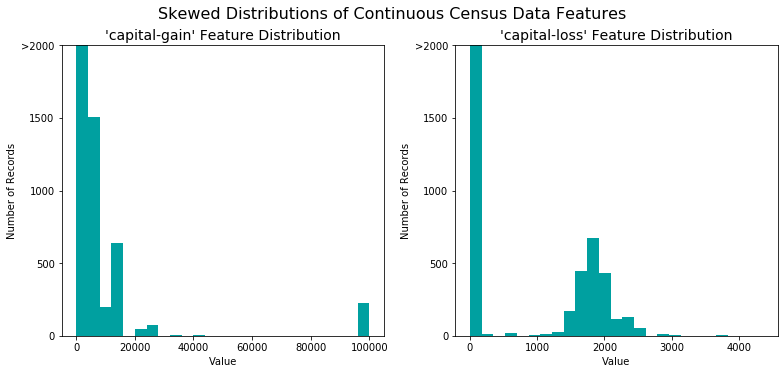

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

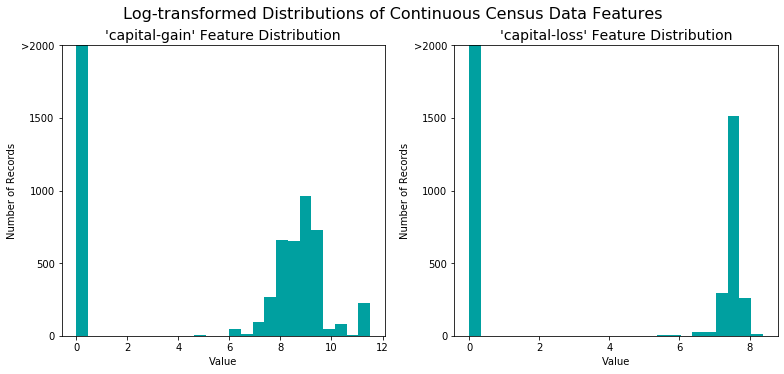

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing

In [6]:
# One-hot encode
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == "<=50K" else 1)

encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))


print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Split Data

In [8]:
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)


print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


### Random Forest: Model Tuning

In [10]:
# Initialize the classifier
clf = RandomForestClassifier(random_state = 17, n_estimators=100, n_jobs=-1)

parameters = {'max_depth': range(6, 12), 'max_features': range(4, 19)}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer'
grid_obj = GridSearchCV(clf, parameters, scorer)
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8443
F-score on testing data: 0.6856

Optimized Model
------
Final accuracy score on the testing data: 0.8575
Final F-score on the testing data: 0.7296


#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8443          |   0.8475        |
| F-score        |   0.6856          |   0.7296        |


### Extracting Feature Importance

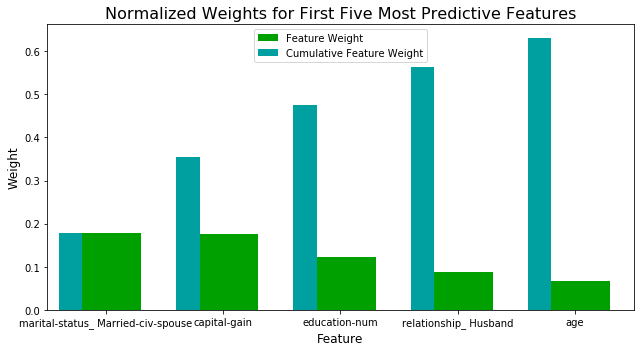

In [11]:
importances = best_clf.feature_importances_

vs.feature_plot(importances, X_train, y_train)